In [88]:
#import pandas as pd
import statsmodels.api as sm
from scipy import interpolate
from pandas import Series, DataFrame, Panel
from string import ascii_lowercase as letters
from scipy.stats import chisqprob
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from scipy.stats import wrapcauchy
import matplotlib.pyplot as plt
%matplotlib inline
%precision 4
plt.style.use('classic')
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from functools import partial
np.random.seed(1234)

In [89]:
def rw2(n):# this gives samples from weibull(5,2)
    x=np.zeros(n)
    y=np.zeros(n)
    theta=[0]*n
    theta[0]=wrapcauchy.rvs(c,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n):
        r=random.weibullvariate(alpha,beta)
        theta[i]=wrapcauchy.rvs(c,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x[i]=x[i-1]+r*math.cos(theta[i])
        y[i]=y[i-1]+r*math.sin(theta[i])
    return(x,y)   
    
n=10000 #sample size
alpha=2 #scale
beta=5 #shape
c=0.9# shape parameter for Wrapped Cauchy distribution, it needs to be between 0 and 1
data = rw2(n)
x=data[0]
y=data[1]
t=range(0,n)

In [90]:
# average distance
def rw2_distance(n):# this gives samples from weibull(5,2)
    x=np.zeros(n)
    y=np.zeros(n)
    theta=[0]*n
    distance=[0]*n
    theta[0]=wrapcauchy.rvs(c,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n):
        r=random.weibullvariate(alpha,beta)
        theta[i]=wrapcauchy.rvs(c,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x[i]=x[i-1]+r*math.cos(theta[i])
        y[i]=y[i-1]+r*math.sin(theta[i])
        distance[i]=(x[i]**2+y[i]**2)**0.5
    return distance 
    
n=10000 #sample size
alpha=2 #scale
beta=5 #shape
c=0.9# shape parameter for Wrapped Cauchy distribution, it needs to be between 0 and 1
data_distance = rw2_distance(n)
t=range(0,n)
#data_distance

In [91]:
number_of_simulations=100# this is the number of rows or row vectors
n=10000# number of columns or number of elements in that row vector
average_distances=np.zeros((number_of_simulations,n))
for i in range(number_of_simulations):
    average_distances[i]=rw2_distance(n)


In [92]:
matrix=np.zeros((2,5))# 2 rows 5 columns
matrix[1]=range(0,5)
matrix[0]=range(5,10)
print(matrix)
print(matrix.mean(axis=0))

[[ 5.  6.  7.  8.  9.]
 [ 0.  1.  2.  3.  4.]]
[ 2.5  3.5  4.5  5.5  6.5]


In [93]:
# the mean average distance after 1 step, 2 steps, etc...

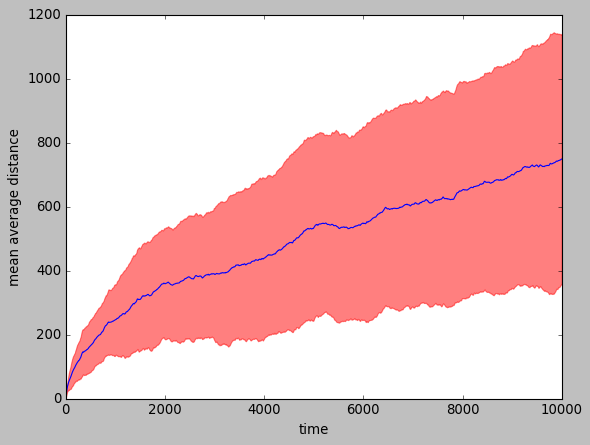

In [94]:
u=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
plt.plot(t,u)
plt.fill_between(t, u-error, u+error,color='red',alpha=0.5)
#plt.plot(t,y-error)
#plt.plot(t,y+error)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()

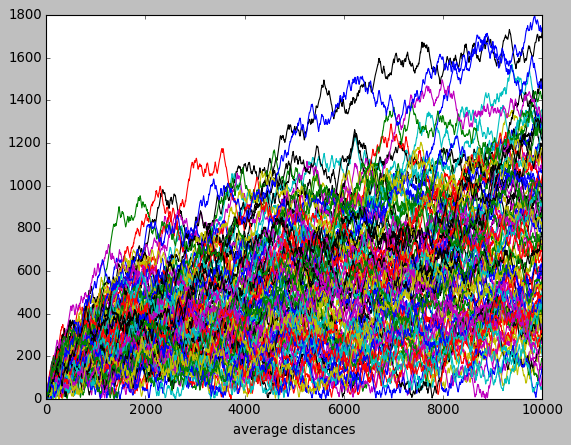

In [95]:
plt.plot(average_distances.T)
plt.xlabel('time')
plt.xlabel('average distances')
plt.show()

In [96]:
# D the diffusion coefficient
D=u**2/(2*np.array(t))
D_coeff=np.mean(D[5000:])
D_coeff

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


26.7434

Text(0,0.5,'Diffusion Coefficient')

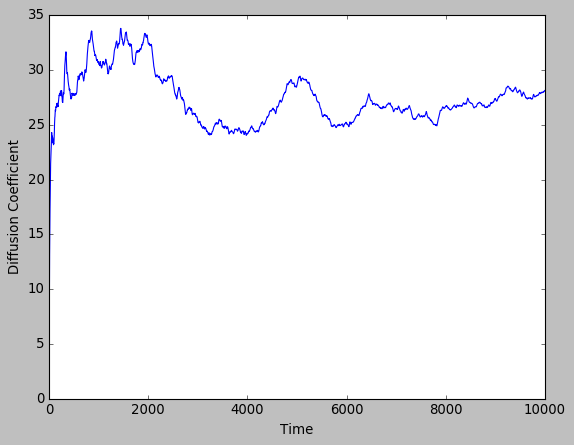

In [97]:
plt.plot(D)
plt.xlabel('Time')
plt.ylabel('Diffusion Coefficient')

In [98]:
# Now put them into the MCMC sampler, the second model is to be considered
import scipy.stats 
from scipy.stats import dweibull
def log_likelihood(x,a,b):# a is shape, b is scale
     return sum(dweibull.logpdf(x,scale=b,c=a))
def log_wclikelihood(x,a,b):
     return sum(wrapcauchy.logpdf(x,c=a,loc=b))# c is the shape parameter

In [99]:
#time_step=2
# my code pretty much starts here
time_step=0.3
t_new=np.arange(0,n-1,time_step)
f=interpolate.interp1d(t,x,kind='cubic')#,fill_value="extrapolate")
g=interpolate.interp1d(t,y,kind='cubic')#,fill_value="extrapolate") don't do this

In [100]:
x_new=f(t_new)
y_new=g(t_new)

In [101]:
#get the distances now and the angles
r=np.zeros(len(x_new)-1)# r the step-lengths
theta=np.zeros(len(x_new)-1)# theta the angle
new_data=np.zeros(len(x_new)-1)
for i in range(0,len(x_new)-1):
    r[i]=np.sqrt((x_new[i+1]-x_new[i])**2 + (y_new[i+1]-y_new[i])**2)
    theta[i]=math.atan2(y_new[i+1]-y_new[i], x_new[i+1]-x_new[i])
for i in range(0,len(x_new)-2):
    new_data[i]=theta[i+1]-theta[i]# save the difference in the heading
    if new_data[i]<0:
        new_data[i]=new_data[i]+2*math.pi    
data=r# save the step-lengths,have the same name as before in the MCMC sampler for the step-lengths
#new_data is the data that we introduce in the heading MCMC sampler
print(len(data))    
print(len(theta))
print(len(new_data))
new_data# it has a zero at the end
new_data=new_data[:-1]
#new_data without zero.
data=data[:-1]# change the step-lengths data as well
print(len(data))
print(len(new_data))# make sure they have the same lenghts

33329
33329
33329
33328
33328


In [102]:
#MCMC sampler for the heading
# initial guess for theta(a) as array,these are shape(c) 
guess = 0.9
# Prepare storing MCMC chain as array of arrays.
A1 = [guess]
# define stepsize of MCMC.
stepsize = 0.0025 # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_wclikelihood(new_data,old_theta,0)#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    new_theta = old_theta + stats.norm(0, stepsize).rvs() 
    #add the restraints on new_theta
    if new_theta<0 or new_theta>1: 
        continue
    new_loglik = log_wclikelihood(new_data,new_theta,0)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A1.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A1.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A1.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.3388


0.953398022013
0.953475638574
19001


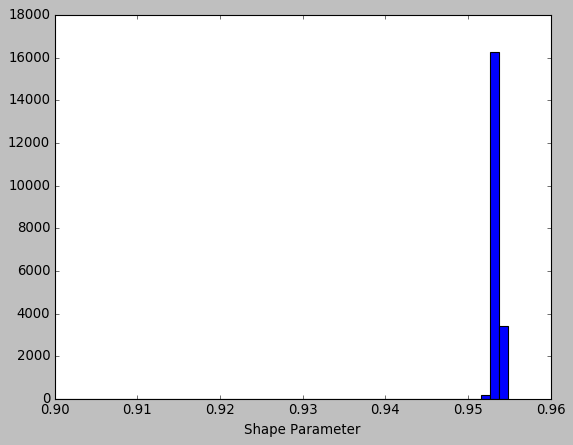

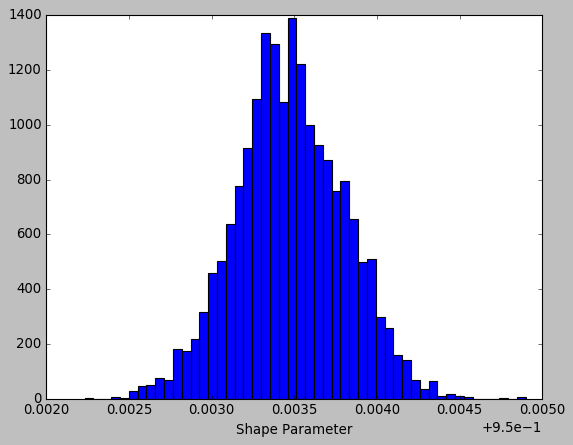

In [103]:
print(np.mean(A1))
print(np.mean(A1[1000:]))# burn in 1000
plt.hist(A1,bins=50)
B1=np.array(A1[1000:])
print(len(B1))
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B1,bins=50)
plt.xlabel("Shape Parameter")
plt.show()

In [104]:
#MCMC sampler for the step-lengths
import scipy.stats as stats
import numpy as np
# initial guess for theta(a and b) as array.
guess = [5.0,2.0]
# Prepare storing MCMC chain as array of arrays.
A2 = [guess]
# define stepsize of MCMC.
stepsizes = [0.006,0.006]  # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_likelihood(data,old_theta[0],old_theta[1])#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    # Suggest new candidate from Gaussian proposal distribution.
    new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
    #add the restraints on new_theta
    if new_theta[0]<0 or new_theta[1]<0: 
        continue
    new_loglik = log_likelihood(data,new_theta[0],new_theta[1])
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A2.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A2.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A2.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.3155


20001
4.4656123584
0.605768675082


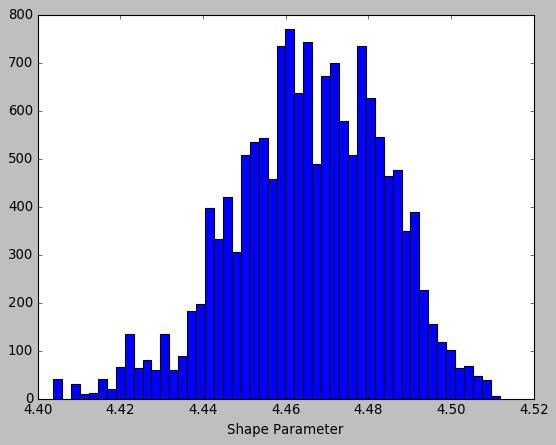

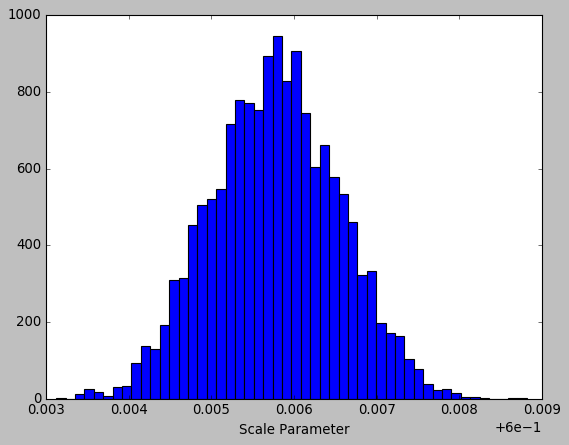

In [105]:
print(len(A2))
B2=np.array(A2[5000:])#burn-in 1000
shape_mean=np.mean(B2[:,0])
scale_mean=np.mean(B2[:,1])
print(shape_mean)
print(scale_mean)
plt.hist(B2[:,0],bins=50)
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B2[:,1],bins=50)# now changing the parameters and n with the ones that I got
plt.xlabel("Scale Parameter")
plt.show()# now changing the parameters and n with the ones that I got



In [106]:
# I need the mean diffusion coefficient for the new data
# calculating the distance from the origin in the new data
# this is just for one sample
distance_origin_new_data=np.zeros(len(x_new))
distance_origin_new_data=(x_new**2+y_new**2)**0.5

In [107]:
number_new_simulations=100
average_new_data_distances=np.zeros((number_new_simulations,len(x_new)))

In [108]:
for i in range(number_new_simulations):
                               data=rw2(n)
                               x=data[0]
                               y=data[1]
                               t_new=np.arange(0,n-1,time_step)
                               f=interpolate.interp1d(t,x,kind='cubic')
                               g=interpolate.interp1d(t,y,kind='cubic')
                               x_new=f(t_new)
                               y_new=g(t_new)
                               distance_origin_new_data=np.zeros(len(x_new))
                               distance_origin_new_data=(x_new**2+y_new**2)**0.5# this becomes the first row and so on of the matrix
                               average_new_data_distances[i,]=distance_origin_new_data

In [109]:
y_new_data=average_new_data_distances.mean(axis=0)

In [110]:
len(y_new_data)

33330

In [111]:
#not fine since this is a much larger vector than the replicate vectors, so that's why I'm getting such different results
 #the mean diffusion coefficient for the original data
#time_1000=t_new[-1000:][::-1]    # I get the first 1000 observations 
mean_D_new_data=np.zeros(len(t_new))#len(t_new[1:]))  # skip zeros # I put 1000 because I have 1000 below
for i in range(len(mean_D_new_data)):
    mean_D_new_data[i]=(y_new_data[i]**2)/(2*t_new[i])
mean_D_new_data_coefficient=np.mean(mean_D_new_data[25000:])
#print(mean_D_new_data)
print(len(mean_D_new_data))
print(mean_D_new_data_coefficient)


33330
24.9447038007


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [112]:
# the diffusion coefficient for all the new data
time_all=t_new
mean_D_all_new_data=np.zeros(len(time_all))
for i in range(len(mean_D_all_new_data)):
    mean_D_all_new_data[i]=(y_new_data[i]**2)/(2*time_all[i])
mean_D_all_new_data_coefficient=np.mean(mean_D_all_new_data[1:])
#print(mean_D_new_data)
print(len(mean_D_all_new_data))
print(mean_D_all_new_data_coefficient)

33330
23.5399069807


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


Text(0,0.5,'Diffusion coefficient')

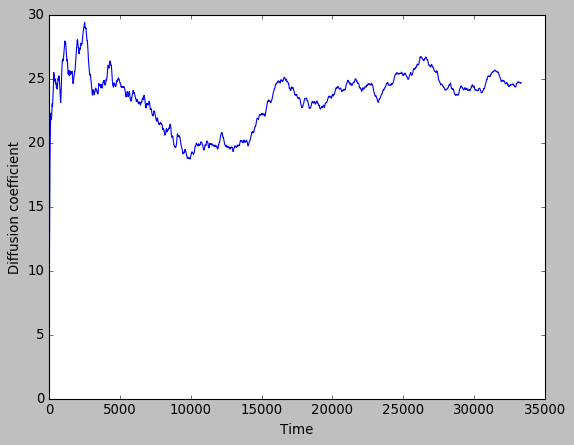

In [113]:
plt.plot(mean_D_all_new_data)
plt.xlabel('Time')
plt.ylabel('Diffusion coefficient')
# I need all of t_new as length of length_datas
#from 25000 onwards it's about a straight line

In [114]:
# I need the mean diffusion coefficient for the data generated by the parameters obtained from inference

In [115]:
# Weibull
shape_parameters=B2[:,0]
scale_parameters=B2[:,1]
# select every 10th observation
shape_parameters_need=shape_parameters[::10][:-1301]# same length now
scale_parameters_need=scale_parameters[::10][:-1301]
#Wrapped Cauchy
shapewc_parameters=B1
shapewc_parameters_need=B1[::10][:-1701]
print(len(shapewc_parameters_need))
print(len(scale_parameters_need))
print(len(shape_parameters_need))

200
200
200


In [116]:
# now changing the parameters and n with the ones that I got
def rw2_change(n_change,alpha_change,beta_change,c_change):# this gives samples from the inference model
    x_change=np.zeros(n_change)
    y_change=np.zeros(n_change)
    theta=np.zeros(n_change)
    distance_origin=np.zeros(n_change)
    distance=np.zeros(n_change)
    theta[0]=wrapcauchy.rvs(c_change,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n_change):
        r=random.weibullvariate(alpha_change,beta_change)
        theta[i]=wrapcauchy.rvs(c_change,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x_change[i]=x_change[i-1]+r*math.cos(theta[i])
        y_change[i]=y_change[i-1]+r*math.sin(theta[i])
        distance_origin[i]=(x_change[i]**2+y_change[i]**2)**0.5
        distance[i]=r
    return [x_change,y_change,distance,theta,distance_origin]   
    
n_change=len(new_data) #int(input("how many steps?"))
alpha_change=scale_parameters_need#int(input("what's the scale?"))
beta_change=shape_parameters_need #int(input("what's the shape?"))
c_change=shapewc_parameters_need# float(input("What's the shape parameter for the wrapped Cauchy?"))# this needs to be between 0 and 1
#x_change = np.array(rw2_change(n_change)[0])
#y_change=np.array(rw2_change(n_change)[1])
#data_change=np.array(rw2_change(n_change)[2])
#theta_change=np.array(rw2_change(n_change)[3])
#the previous code

In [117]:
#print(scale_parameters_need)
#print(shape_parameters_need)
#print(shapewc_parameters_need)
print(n_change)


33328


In [118]:
print(len(shapewc_parameters_need))
print(len(scale_parameters_need))
print(len(shape_parameters_need))
#make them the same size, check again

200
200
200


In [119]:
length_datas=len(t_new)

In [120]:
data_change=np.zeros((len(shape_parameters_need),length_datas))
theta_change=np.zeros((len(shapewc_parameters_need),length_datas))
# do arrays, matrices

In [121]:
print(len(alpha_change))
print(len(shape_parameters_need))
print(length_datas)
print(len(beta_change))
print(len(c_change))
hello=np.array(rw2_change(length_datas,alpha_change[1],beta_change[1],c_change[1])[2])
print(len(np.array(rw2_change(length_datas,alpha_change[1],beta_change[1],c_change[1])[2])))
print(len(np.array(rw2_change(length_datas,alpha_change[1],beta_change[1],c_change[1])[4])))
# works now

200
200
33330
200
200
33330
33330


In [122]:
count=0
for i in range(len(hello)-1):
    if hello[i]==0:
        count+=1
count        
# works now

1

In [123]:
#if you want to make them the same size
print(len(theta_change))
#print(len(theta_original))
#print(len(r_original))
print(len(data_change))
#Let's go to 999 then
#theta_change=theta_change[:999]
#theta_original=theta_original[:999]
#data_change=data_change[:999]
#shape_parameters_need=shape_parameters_need[:999]
#scale_parameters_need=scale_parameters_need[:999]
#shapewc_parameters_need=shapewc_parameters_need[:999]

200
200


In [124]:
# mistake here should be without -1
for i in range(len(shape_parameters_need)):
                     data_change[i,]=np.array(rw2_change(length_datas,alpha_change[i],beta_change[i],c_change[i])[2])#the distances

In [125]:
for i in range(len(shape_parameters_need)):
                     theta_change[i,]=np.array(rw2_change(length_datas,alpha_change[i],beta_change[i],c_change[i])[3])#the angles

In [126]:
#theta_change[1299] again zeros
#data_change[1299] zeros again

In [127]:
up=5
check=np.zeros(5)
length=len(check)
for i in range(0,length):
    check[i]=i+1
check    
# it's a mistake in here , should be len-1

array([ 1.,  2.,  3.,  4.,  5.])

In [128]:
# the mean of the inferred parameters
mean_shape_weibullparameter=np.mean(shape_parameters)
mean_scale_weibullparameter=np.mean(scale_parameters)
mean_shape_wcparameter=np.mean(shapewc_parameters)

In [129]:
# I need to find out the average D from 100 simulations for all the data that I've generated
# this is for 1 data, you need to do it for at least 200
# I need to create a matrix or a list to store my results
number_of_simulations=100
average_distances_change=np.zeros((number_of_simulations,length_datas))
y_change=np.zeros((len(shape_parameters_need),length_datas))
for i in range(len(shape_parameters_need)):
    for j in range(number_of_simulations):
        average_distances_change[j]=rw2_change(length_datas,alpha_change[i],beta_change[i],c_change[i])[4]
    y_change[i]=average_distances_change.mean(axis=0)
# for every set of parameters you run 100 times
# y_change is a matrix that stores on each row the <d> vectors for y_replicate

In [130]:
# calculating the D's the diffusion coefficients
#time_1000=t_new[-1000:][::-1] 
mean_D_replicate=np.zeros((len(shape_parameters_need),length_datas))
mean_D_replicate_coefficient=np.zeros(len(shape_parameters_need))
for i in range(len(shape_parameters_need)):
  #  mean_D_replicate[i]=(y_change[i][::-1]**2)/(2*np.array(time_1000))
    mean_D_replicate[i]=(y_change[i]**2)/(2*np.array(t_new))
    mean_D_replicate_coefficient[i]=np.mean(mean_D_replicate[i][25000:])


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [131]:
# compare the test statistics
T_y=mean_D_new_data_coefficient
T_y_rep=mean_D_replicate_coefficient


In [132]:
T_y

24.9447

In [133]:
#T_y_rep_without_zero=T_y_rep[:-1]

In [134]:
T_y_rep

array([ 18.0418,  17.1181,  14.6673,  19.5781,  19.4127,  18.2758,
        15.6592,  17.9609,  14.2288,  15.7292,  16.4821,  17.6228,
        14.8419,  15.5764,  17.3475,  17.2734,  16.7749,  18.8376,
        18.3845,  18.949 ,  17.1107,  15.4193,  14.3968,  14.7068,
        18.2706,  15.8074,  19.2513,  15.6507,  16.2287,  13.7577,
        17.9085,  15.53  ,  18.5457,  18.8029,  14.8531,  18.6401,
        15.8201,  20.2894,  14.0277,  16.6214,  15.6217,  17.0272,
        17.205 ,  18.1873,  18.5724,  16.1413,  15.6468,  18.3883,
        17.5024,  18.0171,  15.6811,  20.1511,  17.1541,  14.2694,
        19.5095,  18.8132,  14.2123,  18.5772,  16.3164,  17.5922,
        15.6982,  15.9163,  16.7848,  17.0545,  18.6489,  16.1309,
        15.8293,  17.0219,  15.4368,  17.1737,  16.9547,  17.5172,
        17.5573,  17.4887,  15.3827,  17.6564,  17.027 ,  13.9592,
        18.6004,  18.5824,  16.1856,  16.7874,  15.9784,  18.3683,
        14.5511,  15.5917,  19.0652,  17.5996,  17.9681,  19.3

In [135]:
count=0
for i in range(len(shape_parameters_need)):
    if T_y_rep[i]>T_y:
        count+=1
print(count)
print(len(shape_parameters_need))
ppp_value=count/len(shape_parameters_need)
print(ppp_value)


0
200
0.0


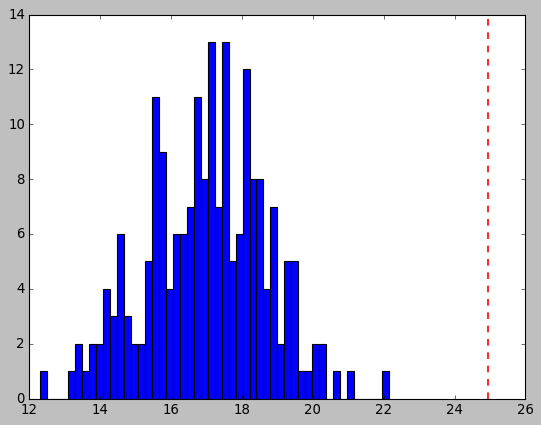

In [136]:
plt.hist(T_y_rep,bins=50)
plt.axvline(T_y,linestyle='dashed', linewidth=1.5,color='red')
plt.show()


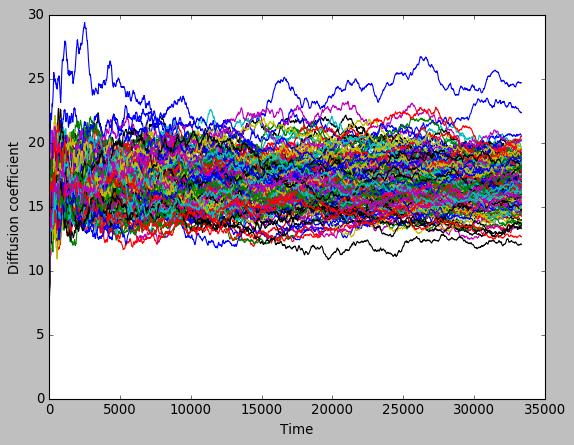

In [137]:
plt.plot(mean_D_new_data)
plt.plot(mean_D_replicate.T)
plt.xlabel('Time')
plt.ylabel('Diffusion coefficient')
plt.show()

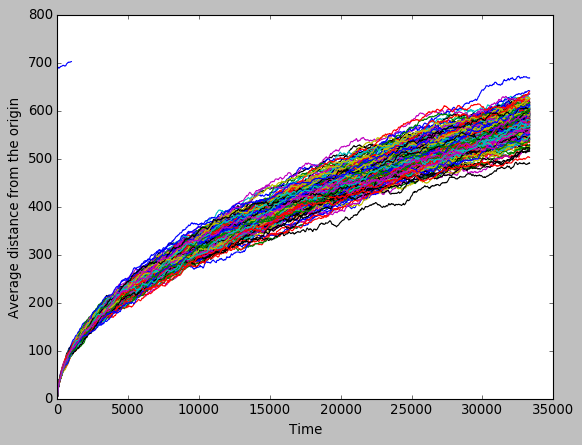

In [138]:
plt.plot(y_new_data[-1000:])
plt.plot(y_change.T)
plt.xlabel('Time')
plt.ylabel('Average distance from the origin')
plt.show()

In [139]:
len(y_change[1])

33330

In [141]:
# I have a mistake in the last 1000 codes, I'm not giving it enough time to grow as large, that's why the differences are so huge

In [142]:
y_change

array([[  0.0000e+00,   5.6447e-01,   1.0972e+00, ...,   5.8566e+02,
          5.8565e+02,   5.8566e+02],
       [  0.0000e+00,   5.7022e-01,   1.1058e+00, ...,   5.7109e+02,
          5.7111e+02,   5.7112e+02],
       [  0.0000e+00,   5.5733e-01,   1.1085e+00, ...,   5.2061e+02,
          5.2068e+02,   5.2075e+02],
       ..., 
       [  0.0000e+00,   5.5618e-01,   1.1039e+00, ...,   5.0313e+02,
          5.0316e+02,   5.0318e+02],
       [  0.0000e+00,   5.4816e-01,   1.0973e+00, ...,   5.8138e+02,
          5.8137e+02,   5.8131e+02],
       [  0.0000e+00,   5.5331e-01,   1.0815e+00, ...,   5.7474e+02,
          5.7479e+02,   5.7484e+02]])

In [143]:
y_new_data

array([  0.0000e+00,   5.9157e-01,   1.1347e+00, ...,   7.0288e+02,
         7.0289e+02,   7.0291e+02])